# AI-*304*



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv("/content/accident.csv")
display(df.head())

,Age,Gender,Speed_of_Impact,Helmet_Used,Seatbelt_Used,Survived
0,56,Female,27.0,No,No,1
1,69,Female,46.0,No,Yes,1
2,46,Male,46.0,Yes,Yes,0
3,32,Male,117.0,No,Yes,0
4,60,Female,40.0,Yes,Yes,0


# **EDA**

In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              200 non-null    int64  
 1   Gender           199 non-null    object 
 2   Speed_of_Impact  197 non-null    float64
 3   Helmet_Used      200 non-null    object 
 4   Seatbelt_Used    200 non-null    object 
 5   Survived         200 non-null    int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 9.5+ KB


In [4]:
df.describe()

,Age,Speed_of_Impact,Survived
count,200.00000,197.000000,200.00000
mean,43.42500,70.441624,0.50500
std,14.94191,30.125298,0.50123
min,18.00000,20.000000,0.00000
25%,31.00000,43.000000,0.00000
50%,43.50000,71.000000,1.00000
75%,56.00000,95.000000,1.00000
max,69.00000,119.000000,1.00000


In [5]:
df.columns

Index(['Age', 'Gender', 'Speed_of_Impact', 'Helmet_Used', 'Seatbelt_Used',
       'Survived'],
      dtype='object')

In [10]:
df.isna().sum()

,0
Age,0
Gender,1
Speed_of_Impact,3
Helmet_Used,0
Seatbelt_Used,0
Survived,0


In [12]:
df.dtypes

,0
Age,int64
Gender,object
Speed_of_Impact,float64
Helmet_Used,object
Seatbelt_Used,object
Survived,int64


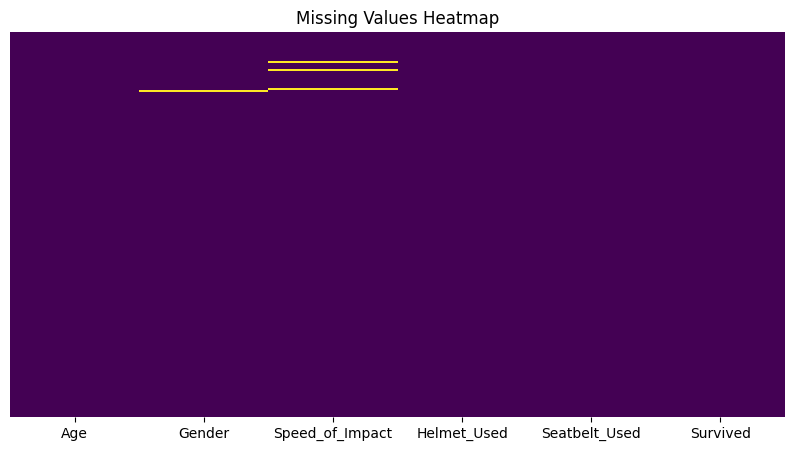

In [13]:
# 1. Missing values heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

In [15]:
df=df.dropna()

In [16]:
df.isna().sum()

,0
Age,0
Gender,0
Speed_of_Impact,0
Helmet_Used,0
Seatbelt_Used,0
Survived,0


In [20]:
df.columns

Index(['Age', 'Gender', 'Speed_of_Impact', 'Helmet_Used', 'Seatbelt_Used',
       'Survived'],
      dtype='object')

# Manual implementation of decesion tree with gini

In [27]:
import numpy as np
import pandas as pd
import itertools

def gini(y):
    if isinstance(y, pd.Series):
        a = y.value_counts() / y.shape[0]
        return 1 - np.sum(a ** 2)
    else:
        raise ValueError("Object must be a Pandas Series.")

In [28]:
def information_gain(y, mask, func=gini):
    a = sum(mask)
    b = mask.shape[0] - a
    if a == 0 or b == 0:
        return 0
    return func(y) - (a / (a + b) * func(y[mask])) - (b / (a + b) * func(y[~mask]))

In [29]:


def categorical_options(a):
    a = a.unique()
    options = []
    for L in range(1, len(a)):
        for subset in itertools.combinations(a, L):
            options.append(list(subset))
    return options


In [30]:

def max_information_gain_split(x, y, func=gini):
    split_value, gain = [], []
    numeric_variable = x.dtypes != 'O'

    options = x.sort_values().unique()[1:] if numeric_variable else categorical_options(x)

    for val in options:
        mask = x < val if numeric_variable else x.isin(val)
        val_gain = information_gain(y, mask, func)
        gain.append(val_gain)
        split_value.append(val)

    if not gain:
        return None, None, None, False

    best_gain_index = np.argmax(gain)
    return gain[best_gain_index], split_value[best_gain_index], numeric_variable, True

def get_best_split(y, dataset):
    masks = dataset.drop(columns=[y]).apply(max_information_gain_split, y=dataset[y])

    if 3 not in masks.index or sum(masks.iloc[3, :].dropna()) == 0:
        return None, None, None, None

    masks = masks.loc[:, masks.iloc[3, :].notna()]

    split_variable = masks.iloc[0].astype(np.float32).idxmax()
    split_value = masks[split_variable][1]
    split_gain = masks[split_variable][0]
    split_numeric = masks[split_variable][2]

    return split_variable, split_value, split_gain, split_numeric

In [31]:

def make_split(variable, value, dataset, is_numeric):
    if is_numeric:
        dataset_1 = dataset[dataset[variable] < value]
        dataset_2 = dataset[dataset[variable] >= value]
    else:
        dataset_1 = dataset[dataset[variable].isin(value)]
        dataset_2 = dataset[~dataset[variable].isin(value)]
    return dataset_1, dataset_2

def make_prediction(dataset, target_factor):
    return dataset.value_counts().idxmax() if target_factor else dataset.mean()

def train_tree(dataset, y, target_factor, max_depth=None, min_samples_split=None, min_information_gain=1e-5, counter=0, max_categories=20):
    if counter == 0:
        for column in dataset.select_dtypes(include=['object']).columns:
            if dataset[column].nunique() > max_categories:
                raise ValueError(f"The variable {column} has too many unique values.")

    if (max_depth is None or counter < max_depth) and (min_samples_split is None or dataset.shape[0] > min_samples_split):
        var, val, gain, var_type = get_best_split(y, dataset)
        if gain is not None and gain >= min_information_gain:
            counter += 1
            left, right = make_split(var, val, dataset, var_type)
            question = f"{var} {'<=' if var_type else 'in'} {val}"
            subtree = {question: [train_tree(left, y, target_factor, max_depth, min_samples_split, min_information_gain, counter),
                                  train_tree(right, y, target_factor, max_depth, min_samples_split, min_information_gain, counter)]}
            return subtree
    return make_prediction(dataset[y], target_factor)

In [32]:



def classify_data(observation, tree):
    question = list(tree.keys())[0]
    var, operator, val = question.split()

    if operator == "<=":
        answer = tree[question][0] if observation[var] <= float(val) else tree[question][1]
    else:
        answer = tree[question][0] if observation[var] in eval(val) else tree[question][1]

    return answer if not isinstance(answer, dict) else classify_data(observation, answer)

In [33]:
tree = train_tree(df, 'Survived', True, max_depth=5, min_samples_split=2, min_information_gain=1e-5)

In [34]:

print("Trained Decision Tree:")
print(tree)


Trained Decision Tree:
{'Age <= 65': [{"Gender in ['Female']": [{'Age <= 40': [{'Speed_of_Impact <= 111.0': [{'Speed_of_Impact <= 36.0': [0, 0]}, {'Age <= 25': [0, 1]}]}, {'Age <= 59': [{'Age <= 49': [0, 1]}, {'Speed_of_Impact <= 40.0': [1, 0]}]}]}, {'Age <= 20': [0, {'Speed_of_Impact <= 117.0': [{'Age <= 43': [1, 1]}, 0]}]}]}, {'Speed_of_Impact <= 51.0': [0, 1]}]}


In [35]:
tree

{'Age <= 65': [{"Gender in ['Female']": [{'Age <= 40': [{'Speed_of_Impact <= 111.0': [{'Speed_of_Impact <= 36.0': [0,
          0]},
        {'Age <= 25': [0, 1]}]},
      {'Age <= 59': [{'Age <= 49': [0, 1]},
        {'Speed_of_Impact <= 40.0': [1, 0]}]}]},
    {'Age <= 20': [0,
      {'Speed_of_Impact <= 117.0': [{'Age <= 43': [1, 1]}, 0]}]}]},
  {'Speed_of_Impact <= 51.0': [0, 1]}]}

In [36]:
new_observation = pd.Series({'Age': 50, 'Gender': 'Male', 'Speed_of_Impact': 30, 'Helmet_Used': 'Yes', 'Seatbelt_Used': 'No'})
prediction = classify_data(new_observation, tree)
print("Predicted Class:", prediction)


Predicted Class: 1


In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Get true labels
y_true = df['Survived']

# Predict labels using the trained tree
y_pred = df.apply(lambda x: classify_data(x, tree), axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.6531
Precision: 0.6379
Recall: 0.7400
F1 Score: 0.6852


In [38]:
import json

def pretty_print_tree(tree, indent=""):
    if not isinstance(tree, dict):  # If it's a leaf node (final prediction)
        print(indent + "Predict:", tree)
        return
    for question, subtrees in tree.items():
        print(indent + question)
        print(indent + "├── True:")
        pretty_print_tree(subtrees[0], indent + "│   ")
        print(indent + "└── False:")
        pretty_print_tree(subtrees[1], indent + "    ")

# Print the tree
pretty_print_tree(tree)


Age <= 65
├── True:
│   Gender in ['Female']
│   ├── True:
│   │   Age <= 40
│   │   ├── True:
│   │   │   Speed_of_Impact <= 111.0
│   │   │   ├── True:
│   │   │   │   Speed_of_Impact <= 36.0
│   │   │   │   ├── True:
│   │   │   │   │   Predict: 0
│   │   │   │   └── False:
│   │   │   │       Predict: 0
│   │   │   └── False:
│   │   │       Age <= 25
│   │   │       ├── True:
│   │   │       │   Predict: 0
│   │   │       └── False:
│   │   │           Predict: 1
│   │   └── False:
│   │       Age <= 59
│   │       ├── True:
│   │       │   Age <= 49
│   │       │   ├── True:
│   │       │   │   Predict: 0
│   │       │   └── False:
│   │       │       Predict: 1
│   │       └── False:
│   │           Speed_of_Impact <= 40.0
│   │           ├── True:
│   │           │   Predict: 1
│   │           └── False:
│   │               Predict: 0
│   └── False:
│       Age <= 20
│       ├── True:
│       │   Predict: 0
│       └── False:
│           Speed_of_Impact <= 117.0
│           ├──

# Implementation by scikitlearn

In [39]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



In [40]:



# Convert categorical variables to numerical
data_encoded = pd.get_dummies(df, drop_first=True)

# Separate features and target variable
X = data_encoded.drop(columns=['Survived'])
y = data_encoded['Survived']

# Train a decision tree classifier
clf = DecisionTreeClassifier(max_depth=5, min_samples_split=2, random_state=42)
clf.fit(X, y)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [41]:
clf

DecisionTreeClassifier(max_depth=5, random_state=42)

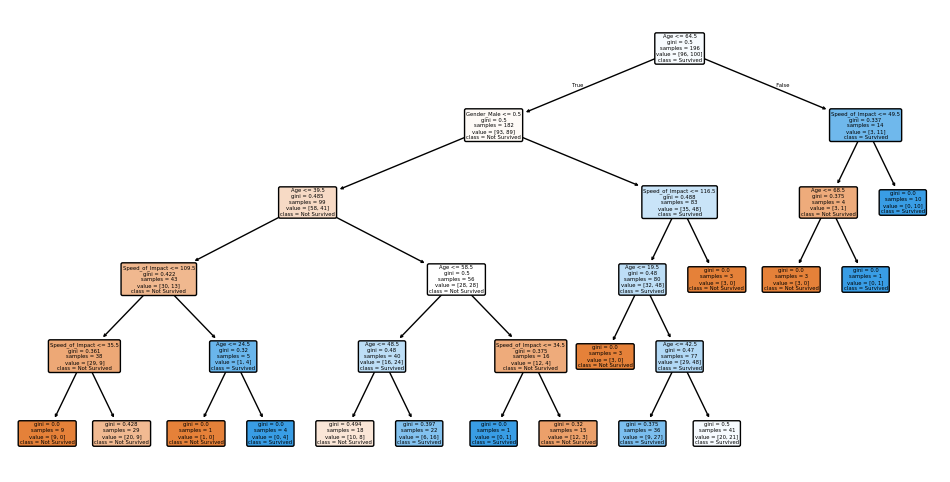

In [42]:
plt.figure(figsize=(12, 6))
tree.plot_tree(clf, feature_names=X.columns, class_names=['Not Survived', 'Survived'], filled=True, rounded=True)
plt.show()


In [43]:
# Make predictions
y_pred = clf.predict(X)

# Calculate evaluation metrics
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)

# Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.72
Precision: 0.70
Recall: 0.80
F1 Score: 0.74
